In [13]:
import numpy as np


In [14]:
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

In [15]:
from scipy.io import loadmat

In [16]:
# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :
        
        Conv_name = "conv"+str(block_no)+"_"+str(i+1)
        
        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))
    
    Max_pooling_name = "pool"+str(block_no)
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))
    
    return Layers

In [17]:
def FCN_8_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))
    
    for l in Convblock(64,1,2) :
        model.add(l)
    
    for l in Convblock(128,2,2):
        model.add(l)
    
    for l in Convblock(256,3,3):
        model.add(l)
    
    for l in Convblock(512,4,3):
        model.add(l)
    
    for l in Convblock(512,5,3):
        model.add(l)
        
    model.add(Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc6"))
      
    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))
    
    # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))
    
    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    #print(Conv_size)
    
    model.add(Deconvolution2D(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))
    
    # O = ((I-K+2*P)/Stride)+1 
    # O = Output dimesnion after convolution
    # I = Input dimnesion
    # K = kernel Size
    # P = Padding
    
    # I = (O-1)*Stride + K 
    Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512
    
    #print(Deconv_size)
    # 2 if image size is 512*512
    Extra = (Deconv_size - 2*Conv_size)
    
    #print(Extra)
    
    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))
    
    return model
    
    

In [18]:
output = FCN_8_helper(512)
print(len(output.layers))

24


In [19]:
output.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 512, 512, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 512, 512, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 512, 512, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 256, 256, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 256, 256, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 128, 128, 128)     0         
__________

In [20]:
def FCN_8(image_size):
    fcn_8 = FCN_8_helper(image_size)
    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_8.layers[-1].output_shape[2] 
    
    #Conv to be applied on Pool4
    skip_con1 = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")
    
    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con1(fcn_8.layers[14].output),fcn_8.layers[-1].output])
    
    #Upsampling output of first skip connection
    x = Deconvolution2D(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score4")(Summed)
    x = Cropping2D(cropping=((0,2),(0,2)))(x)
    
    
    #Conv to be applied to pool3
    skip_con2 = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool3")
    
    #Adding skip connection which takes output og Max pooling layer 3 to current layer
    Summed = add(inputs = [skip_con2(fcn_8.layers[10].output),x])
    
    #Final Up convolution which restores the original image size
    Up = Deconvolution2D(21,kernel_size=(16,16),strides = (8,8),
                         padding = "valid",activation = None,name = "upsample")(Summed)
    
    #Cropping the extra part obtained due to transpose convolution
    final = Cropping2D(cropping = ((0,8),(0,8)))(Up)
    
    
    return Model(fcn_8.input, final)

In [21]:
model = FCN_8(512)

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_4_input (InputLayer)     (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
permute_4 (Permute)              (None, 512, 512, 3)   0           permute_4_input[0][0]            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 512, 512, 64)  1792        permute_4[0][0]                  
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 512, 512, 64)  36928       conv1_1[0][0]                    
___________________________________________________________________________________________

In [23]:
from keras.utils import plot_model

In [24]:
plot_model(model,"FCN-8with_shapes.png",show_shapes=True)

In [25]:
#Loading weights from matlab file
data = loadmat('pascal-fcn8s-dag .mat', matlab_compatible=False, struct_as_record=False)
layers = data['layers']
params = data['params']
description = data['meta'][0,0].classes[0,0].description

In [26]:
print(data.keys())

['layers', 'vars', '__header__', '__globals__', 'meta', 'params', '__version__']


In [27]:
print(layers.shape)

(1, 46)


In [28]:
#Inspecting layer names given in .mat file
for i in range(layers.shape[1]):
    print(i,
          str(layers[0,i].name[0]), str(layers[0,i].type[0]),
          [str(n[0]) for n in layers[0,i].inputs[0,:]],
          [str(n[0]) for n in layers[0,i].outputs[0,:]])

(0, 'conv1_1', 'dagnn.Conv', ['data'], ['conv1_1'])
(1, 'relu1_1', 'dagnn.ReLU', ['conv1_1'], ['conv1_1x'])
(2, 'conv1_2', 'dagnn.Conv', ['conv1_1x'], ['conv1_2'])
(3, 'relu1_2', 'dagnn.ReLU', ['conv1_2'], ['conv1_2x'])
(4, 'pool1', 'dagnn.Pooling', ['conv1_2x'], ['pool1'])
(5, 'conv2_1', 'dagnn.Conv', ['pool1'], ['conv2_1'])
(6, 'relu2_1', 'dagnn.ReLU', ['conv2_1'], ['conv2_1x'])
(7, 'conv2_2', 'dagnn.Conv', ['conv2_1x'], ['conv2_2'])
(8, 'relu2_2', 'dagnn.ReLU', ['conv2_2'], ['conv2_2x'])
(9, 'pool2', 'dagnn.Pooling', ['conv2_2x'], ['pool2'])
(10, 'conv3_1', 'dagnn.Conv', ['pool2'], ['conv3_1'])
(11, 'relu3_1', 'dagnn.ReLU', ['conv3_1'], ['conv3_1x'])
(12, 'conv3_2', 'dagnn.Conv', ['conv3_1x'], ['conv3_2'])
(13, 'relu3_2', 'dagnn.ReLU', ['conv3_2'], ['conv3_2x'])
(14, 'conv3_3', 'dagnn.Conv', ['conv3_2x'], ['conv3_3'])
(15, 'relu3_3', 'dagnn.ReLU', ['conv3_3'], ['conv3_3x'])
(16, 'pool3', 'dagnn.Pooling', ['conv3_3x'], ['pool3'])
(17, 'conv4_1', 'dagnn.Conv', ['pool3'], ['conv4_1'])


In [29]:
#Inspecting filter and bias sizes 
for i in range(0, params.shape[1]-1, 2):
    print(i,
          str(params[0,i].name[0]), params[0,i].value.shape,
          str(params[0,i+1].name[0]), params[0,i+1].value.shape)

(0, 'conv1_1_filter', (3, 3, 3, 64), 'conv1_1_bias', (64, 1))
(2, 'conv1_2_filter', (3, 3, 64, 64), 'conv1_2_bias', (64, 1))
(4, 'conv2_1_filter', (3, 3, 64, 128), 'conv2_1_bias', (128, 1))
(6, 'conv2_2_filter', (3, 3, 128, 128), 'conv2_2_bias', (128, 1))
(8, 'conv3_1_filter', (3, 3, 128, 256), 'conv3_1_bias', (256, 1))
(10, 'conv3_2_filter', (3, 3, 256, 256), 'conv3_2_bias', (256, 1))
(12, 'conv3_3_filter', (3, 3, 256, 256), 'conv3_3_bias', (256, 1))
(14, 'conv4_1_filter', (3, 3, 256, 512), 'conv4_1_bias', (512, 1))
(16, 'conv4_2_filter', (3, 3, 512, 512), 'conv4_2_bias', (512, 1))
(18, 'conv4_3_filter', (3, 3, 512, 512), 'conv4_3_bias', (512, 1))
(20, 'conv5_1_filter', (3, 3, 512, 512), 'conv5_1_bias', (512, 1))
(22, 'conv5_2_filter', (3, 3, 512, 512), 'conv5_2_bias', (512, 1))
(24, 'conv5_3_filter', (3, 3, 512, 512), 'conv5_3_bias', (512, 1))
(26, 'fc6_filter', (7, 7, 512, 4096), 'fc6_bias', (4096, 1))
(28, 'fc7_filter', (1, 1, 4096, 4096), 'fc7_bias', (4096, 1))
(30, 'score_fr_filt

In [30]:
params.shape

(1, 40)

In [31]:
for i in range(0, params.shape[1]):
    print(i,
          str(params[0,i].name[0]), params[0,i].value.shape)

(0, 'conv1_1_filter', (3, 3, 3, 64))
(1, 'conv1_1_bias', (64, 1))
(2, 'conv1_2_filter', (3, 3, 64, 64))
(3, 'conv1_2_bias', (64, 1))
(4, 'conv2_1_filter', (3, 3, 64, 128))
(5, 'conv2_1_bias', (128, 1))
(6, 'conv2_2_filter', (3, 3, 128, 128))
(7, 'conv2_2_bias', (128, 1))
(8, 'conv3_1_filter', (3, 3, 128, 256))
(9, 'conv3_1_bias', (256, 1))
(10, 'conv3_2_filter', (3, 3, 256, 256))
(11, 'conv3_2_bias', (256, 1))
(12, 'conv3_3_filter', (3, 3, 256, 256))
(13, 'conv3_3_bias', (256, 1))
(14, 'conv4_1_filter', (3, 3, 256, 512))
(15, 'conv4_1_bias', (512, 1))
(16, 'conv4_2_filter', (3, 3, 512, 512))
(17, 'conv4_2_bias', (512, 1))
(18, 'conv4_3_filter', (3, 3, 512, 512))
(19, 'conv4_3_bias', (512, 1))
(20, 'conv5_1_filter', (3, 3, 512, 512))
(21, 'conv5_1_bias', (512, 1))
(22, 'conv5_2_filter', (3, 3, 512, 512))
(23, 'conv5_2_bias', (512, 1))
(24, 'conv5_3_filter', (3, 3, 512, 512))
(25, 'conv5_3_bias', (512, 1))
(26, 'fc6_filter', (7, 7, 512, 4096))
(27, 'fc6_bias', (4096, 1))
(28, 'fc7_filter

In [32]:
#Note : We are not transfering the weights of score4, score_pool3 and upsample because it doesn't follow the same 
# convention. The weights and biases for them are transferred below seperately

def copy_mat_of_keras(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, 35, 2):
        matname = '_'.join(params[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            print(matname)
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = params[0,i].value
            l_bias = params[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            print(f_l_weights.shape)
            print("layer")
            print(kmodel.layers[kindex].get_weights()[0].shape)
            print("layer")
            assert (l_bias.shape[1] == 1)
            print(l_bias[:,0].shape)
            print("bias")
            print(kmodel.layers[kindex].get_weights()[1].shape)
            print("bias")
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))
    return kmodel

In [33]:
model = copy_mat_of_keras(model)

conv1_1
('found : ', ('conv1_1', 2))
((3, 3, 3, 64), (3, 3, 3, 64))
(3, 3, 3, 64)
layer
(3, 3, 3, 64)
layer
(64,)
bias
(64,)
bias
conv1_2
('found : ', ('conv1_2', 3))
((3, 3, 64, 64), (3, 3, 64, 64))
(3, 3, 64, 64)
layer
(3, 3, 64, 64)
layer
(64,)
bias
(64,)
bias
conv2_1
('found : ', ('conv2_1', 5))
((3, 3, 64, 128), (3, 3, 64, 128))
(3, 3, 64, 128)
layer
(3, 3, 64, 128)
layer
(128,)
bias
(128,)
bias
conv2_2
('found : ', ('conv2_2', 6))
((3, 3, 128, 128), (3, 3, 128, 128))
(3, 3, 128, 128)
layer
(3, 3, 128, 128)
layer
(128,)
bias
(128,)
bias
conv3_1
('found : ', ('conv3_1', 8))
((3, 3, 128, 256), (3, 3, 128, 256))
(3, 3, 128, 256)
layer
(3, 3, 128, 256)
layer
(256,)
bias
(256,)
bias
conv3_2
('found : ', ('conv3_2', 9))
((3, 3, 256, 256), (3, 3, 256, 256))
(3, 3, 256, 256)
layer
(3, 3, 256, 256)
layer
(256,)
bias
(256,)
bias
conv3_3
('found : ', ('conv3_3', 10))
((3, 3, 256, 256), (3, 3, 256, 256))
(3, 3, 256, 256)
layer
(3, 3, 256, 256)
layer
(256,)
bias
(256,)
bias
conv4_1
('found : '

In [34]:
kerasnames = [lr.name for lr in model.layers]

In [35]:
kerasnames


['permute_4_input',
 'permute_4',
 'conv1_1',
 'conv1_2',
 'pool1',
 'conv2_1',
 'conv2_2',
 'pool2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'pool3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'pool4',
 'conv5_1',
 'conv5_2',
 'conv5_3',
 'pool5',
 'fc6',
 'fc7',
 'score_fr',
 'score2',
 'score_pool4',
 'cropping2d_6',
 'add_3',
 'score4',
 'score_pool3',
 'cropping2d_7',
 'add_4',
 'upsample',
 'cropping2d_8']

In [36]:
#Getting the index of layer by name
kindex = kerasnames.index('score4')

In [37]:
kindex

27

In [38]:
l_weights = params[0,36].value

In [39]:
l_weights.shape

(4, 4, 21, 21)

In [40]:
bias = np.zeros(21)

In [41]:
#Giving weights and bias to corresponding layer
#Note : Bias is given as zero as it is absent in the .mat file
model.layers[27].set_weights([l_weights,bias])

In [42]:
#Getting the index of layer by name
kindex = kerasnames.index('score_pool3')

In [43]:
kindex

28

In [44]:
l_weights = params[0,37].value

In [45]:
l_weights.shape

(1, 1, 256, 21)

In [46]:
bias = params[0,38].value

In [47]:
bias.shape

(21, 1)

In [48]:
bias = bias[:,0]

In [49]:
bias.shape

(21,)

In [50]:
#Giving weights and bias to corresponding layer
model.layers[28].set_weights([l_weights,bias])

In [51]:
#Getting the index of layer by name
kindex = kerasnames.index('upsample')

In [52]:
kindex

31

In [53]:
lweights = params[0,39].value

In [54]:
lweights.shape

(16, 16, 21, 21)

In [55]:
bias = np.zeros(21)

In [56]:
#Giving weights and bias to corresponding layer
#Note : Bias is given as zero as it is absent in the .mat file
model.layers[31].set_weights([lweights,bias])

In [57]:
from skimage.io import imread, imsave

In [59]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [88]:
im = Image.open('TestImages/2007_000033.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))

(512, 512, 3)


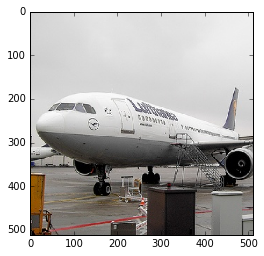

In [89]:
plt.imshow(np.asarray(im))
imsave("orginal_1.png",im)
print(np.asarray(im).shape)

In [90]:
import copy
import math

In [91]:
def prediction(kmodel, crpimg, transform=False):
	# INFO : crpimg should be a cropped image of the right dimension


	imarr = np.array(crpimg).astype(np.float32)

	if transform:
		imarr[:, :, 0] -= 129.1863
		imarr[:, :, 1] -= 104.7624
		imarr[:, :, 2] -= 93.5940
		
		aux = copy.copy(imarr)
		imarr[:, :, 0] = aux[:, :, 2]
		imarr[:, :, 2] = aux[:, :, 0]

	# imarr[:,:,0] -= 129.1863
	# imarr[:,:,1] -= 104.7624
	# imarr[:,:,2] -= 93.5940

	# imarr = imarr.transpose((2, 0, 1))
	imarr = np.expand_dims(imarr, axis=0)

	return kmodel.predict(imarr)

In [92]:
crpim = im 
preds = prediction(model, crpim, transform=False) 

(1, 512, 512, 21)
<type 'numpy.ndarray'>
512
(512, 512)
(512, 512)


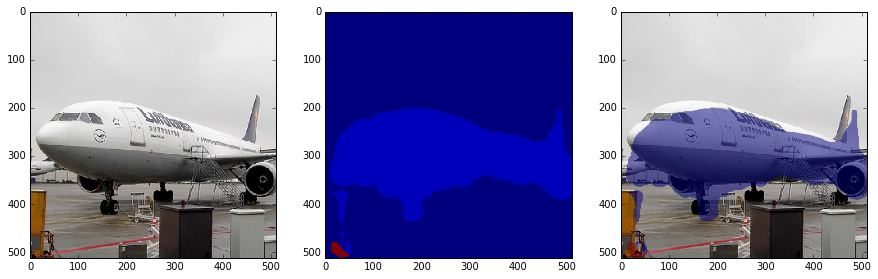

In [93]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
imsave("annotation1_fcn8.png",imclass)
print(type(imclass))
print(len(imclass))
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [94]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(1, 'aeroplane')
(19, 'train')


In [95]:
im = Image.open('TestImages/2007_000032.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))

(512, 512, 3)


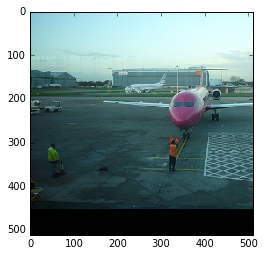

In [96]:
plt.imshow(np.asarray(im))
imsave("orginal2.png",im)
print(np.asarray(im).shape)

In [97]:
crpim = im 
preds = prediction(model, crpim, transform=False) 

(1, 512, 512, 21)
<type 'numpy.ndarray'>
512
(512, 512)
(512, 512)


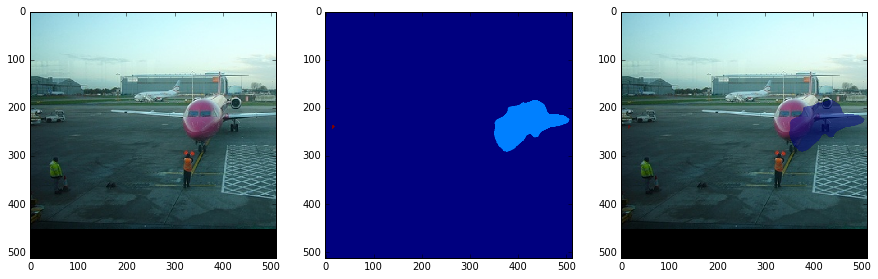

In [98]:
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(type(imclass))
print(len(imclass))
imsave("annotation2_fcn8.png",imclass)
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [70]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(1, 'aeroplane')
(19, 'train')


In [71]:
im = Image.open('TestImages/rgb.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))

(512, 512, 3)


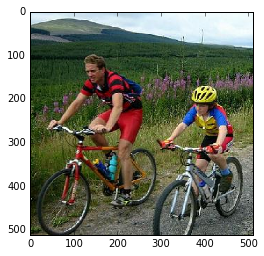

In [72]:
plt.imshow(np.asarray(im))
imsave("orginal3.png",im)
print(np.asarray(im).shape)

In [73]:
crpim = im 
preds = prediction(model, crpim, transform=False) 

(1, 512, 512, 21)
<type 'numpy.ndarray'>
512
(512, 512)
(512, 512)


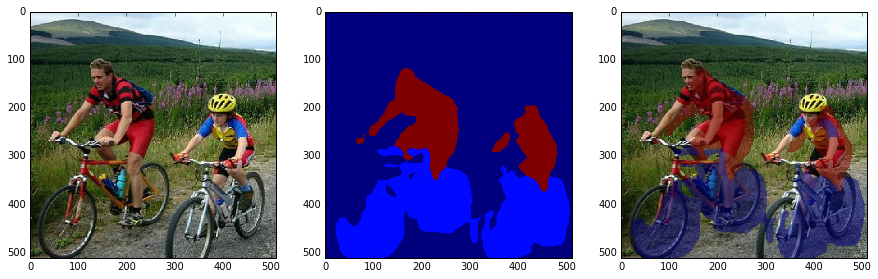

In [74]:
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
imsave("annotation3_fcn8.png",imclass)
print(type(imclass))
print(len(imclass))
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [75]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(2, 'bicycle')
(15, 'person')


In [76]:
im = Image.open('TestImages/2012_003238.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))

(512, 512, 3)


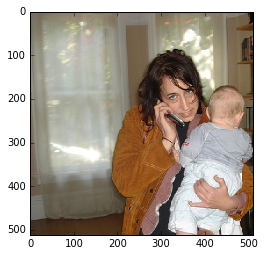

In [78]:
plt.imshow(np.asarray(im))
imsave("orginal4.png",im)
print(np.asarray(im).shape)

In [79]:
crpim = im 
preds = prediction(model, crpim, transform=False) 

(1, 512, 512, 21)
<type 'numpy.ndarray'>
512
(512, 512)
(512, 512)


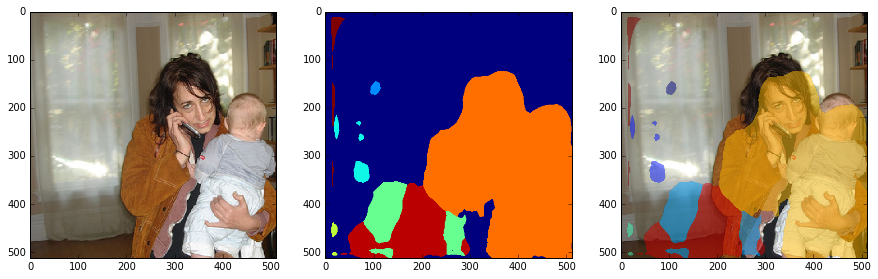

In [82]:
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
imsave("annotation4_fcn8.png",imclass)
print(type(imclass))
print(len(imclass))
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [81]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(5, 'bottle')
(7, 'car')
(9, 'chair')
(11, 'diningtable')
(15, 'person')
(18, 'sofa')
(19, 'train')
